In [1]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [2]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## User Defined Functions

#### KLLR for Covariance

In [3]:
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

#### Likelihood functions and fit

In [4]:
from mcmc_full_models import *

## Data vectors

In [5]:
from data_bins import r_cent_lin_norm, r_cent_log_norm
from data_bins import mass_bins, mass_bin_cent
from data_bins import a_bins

### Dictionary of model specifications

In [6]:
model_dict ={'logistics':{'Ndim':4, 'model_func':model_logistics, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             'algebraic_2nd':{'Ndim':4, 'model_func':model_algebraic_2nd, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             'arctan':{'Ndim':4, 'model_func':model_arctan, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             'erf':{'Ndim':4, 'model_func':model_erf, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         }
            }

### Benchmark Testing using one bin

z=0.00, [1e14,2e14] normalized by R200c. 

In [ ]:
nBootstrap = 10
mass_min = 5e14; mass_max = 1e15
cur_a_bin = 0.6712

mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
cur_df = matched_halo_df[mask]
print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))
            
##Computing the Covariance##
##Compute Cov. and error total
xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                np.log10(np.array(cur_df['Ngal_Dsep_1'],dtype=float)), nBootstrap=nBootstrap)
cov_ds_ngal_kllr = output['covariance']
cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        
##Data vector for chains
x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr
        


In [ ]:
## Testing out the functions

for k,v in model_dict.items():
    #Ndim = model_dict['logistics']['Ndim']
    print(k)
    model = v['model_func']
    x0 = v['x0']
    plt.plot(x_data, model(x0, x_data), label=k)
    
plt.errorbar(x_data, y_data, yerr=y_err, label='Data')
plt.legend()
plt.show()

In [ ]:
import corner
##Running the chains
Nwalker = 50
Nsample = int(1e4)

mass_min = 5e14; mass_max = 1e15
cur_a_bin = 0.6712

redshift = 1/cur_a_bin - 1
redshift_str = '{:.2f}'.format(redshift)
redshift_str = redshift_str.replace('.','p')

mpl.style.use('default')
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,8), sharex=True)

i=0
for k,v in model_dict.items():
    if k != 'erf': continue
    print(k)
    Ndim = v['Ndim']
    model = v['model_func']
    x0 = v['x0']
    
    
    filename = datadir+"test_chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, k)

    best_fit_params, chain = run_model_chains(Nwalker, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                     burn_in=500, thin=100, maxlag=1000, savefile=False, filename=filename, verbose=True)
    
    model_dict[k]['x_final'] = best_fit_params
    Ndim = model_dict[k]['Ndim']
    fit = model(best_fit_params[:,0], x_data)
    
    flatchain=chain.reshape((-1,Ndim)).T
    best_fit_params, DIC_model, BIC_model, p_val = posterior_summary_stats(flatchain, model, Ndim, x_data, y_data, y_err, verbose=True)
    
    a0.plot(x_data, fit, label=k, color='C{}'.format(i), linewidth=3)
    a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(i), label=k)
    i+=1
    
a0.axhline(0, linestyle='--', color='black')
a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='green')  
a0.legend(loc='upper left', fontsize=20)
a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

a1.axhline(0, linestyle='--', color='black')
#a1.set_ylim([-6e11,3e11])
a1.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})^{\rm Obs} - \rm{Cov}(\Delta\Sigma, N_{\rm gal})^{\rm Fit}$', fontsize=14)
a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(5e13,1e14,0.00), fontsize=20)

f.tight_layout()
#f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
plt.show()


In [ ]:
plt.plot(chain[:,1,0])

In [ ]:
import corner
tmp = corner.corner(flatchain.T, labels=['gamma', 'tau', 'h', r'$10^{12}\times s$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e10,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
#tmp.savefig(plot_dir + 'mcmc_logistic_cornerplot.pdf')

In [ ]:
plot_best_fit_params(model_dict)

### Run for all

### Binning and configuration

In [7]:
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
#mass_bin_edges = [5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]
#a_bins = [1, 0.6712, 0.4922]
a_bins = [0.6712]

In [18]:
## MCMC config
Nwalkers = 50
Nsample = int(2e4)
burn_in = 500
thin = 50 
maxlag=1000
#x0 = [0.5,-0.5,-1,1e11]

In [33]:
radius_bins_dir = {'R200c_binned_Dsep_1Mpc':'R200c_binned/Dsep_1/', \
                   'R200c_binned_Dsep_R200c':'R200c_binned/Dsep_R200c/', \
                   'Rvir_binned_Dsep_1':'Rvir_binned/Dsep_1/', \
                   'Rvir_binned_Dsep_Rvir':'Rvir_binned/Dsep_Rvir/'}

M5e+13-1e+14, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 533.584006
         Iterations: 246
         Function evaluations: 539


100%|██████████| 10000/10000 [01:05<00:00, 153.57it/s]


param_0: best fit, upper_err, lower_err:  [0.47387567 0.06055019 0.04950391]
param_1: best fit, upper_err, lower_err:  [-0.65896925  0.08345917  0.1128544 ]
param_2: best fit, upper_err, lower_err:  [-0.98912775  0.0051981   0.00449682]
param_3: best fit, upper_err, lower_err:  [2.88389103e+12 7.15520940e+11 4.65724986e+11]
DIC:  [1075.23490694]
BIC:  [1079.18888173]
Chi-square p-value:  0.15758028422746329
Starting params:  [ 4.65593934e-01 -6.46333562e-01 -9.88631306e-01  2.81757018e+12] Minimization convergence:  True
Autocorrelation:  [68.52727024 73.48934874 50.73043059 79.91771669]
R = [1.00261142 1.00210474 1.00197001 1.0017385 ]


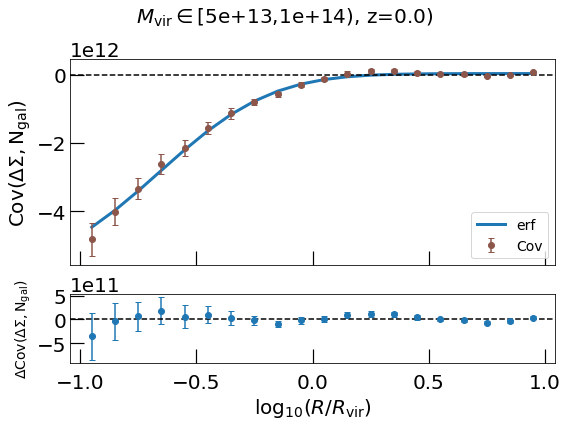

M5e+13-1e+14, z=0.49, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 527.665974
         Iterations: 230
         Function evaluations: 515


100%|██████████| 10000/10000 [01:05<00:00, 153.65it/s]


param_0: best fit, upper_err, lower_err:  [0.26536773 0.0477199  0.04428751]
param_1: best fit, upper_err, lower_err:  [-0.33989939  0.05180085  0.0592958 ]
param_2: best fit, upper_err, lower_err:  [-0.97772178  0.01415917  0.01383299]
param_3: best fit, upper_err, lower_err:  [7.55456817e+11 1.05595684e+11 8.72401895e+10]
DIC:  [1063.52344623]
BIC:  [1067.36836185]
Chi-square p-value:  0.4249302930802721
Starting params:  [ 2.61257166e-01 -3.35820145e-01 -9.77523852e-01  7.59492677e+11] Minimization convergence:  True
Autocorrelation:  [43.34206487 44.28553061 46.4160278  43.63313268]
R = [0.99988813 1.00005257 1.00071411 1.00047522]


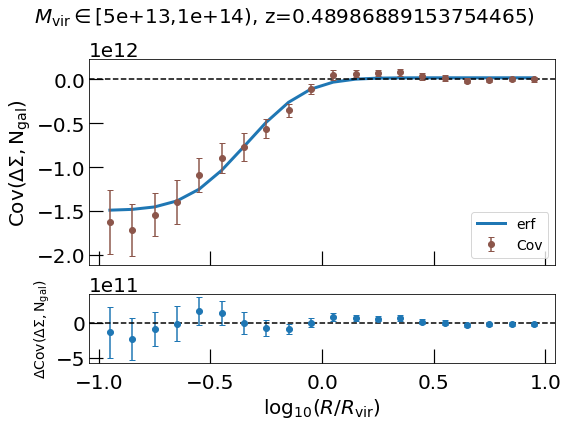

M5e+13-1e+14, z=1.03, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 536.879586
         Iterations: 291
         Function evaluations: 606


100%|██████████| 10000/10000 [01:05<00:00, 151.61it/s]


param_0: best fit, upper_err, lower_err:  [0.17099537 0.05053094 0.04426226]
param_1: best fit, upper_err, lower_err:  [-0.31800075  0.04925867  0.05487929]
param_2: best fit, upper_err, lower_err:  [-1.01929796  0.0204071   0.02238938]
param_3: best fit, upper_err, lower_err:  [3.54655838e+11 6.09875779e+10 5.30360514e+10]
DIC:  [1082.14630361]
BIC:  [1085.8390022]
Chi-square p-value:  0.00018447226877116307
Starting params:  [ 1.69084168e-01 -3.15182775e-01 -1.01862741e+00  3.62879252e+11] Minimization convergence:  True
Autocorrelation:  [47.0535246  49.52497031 47.72576041 52.47337896]
R = [1.00054232 1.00119831 1.00100197 1.00124558]


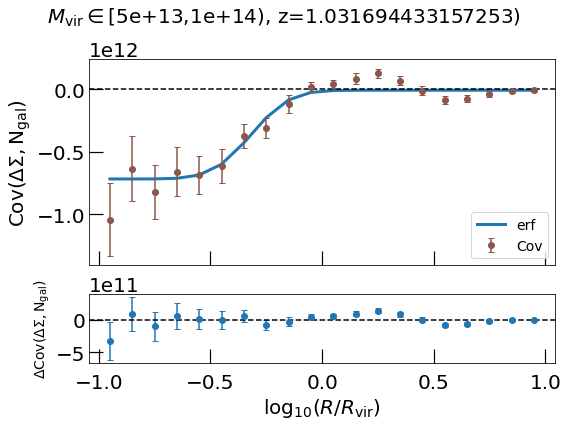

M1e+14-2e+14, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 524.997709
         Iterations: 291
         Function evaluations: 621


100%|██████████| 10000/10000 [01:05<00:00, 151.71it/s]


param_0: best fit, upper_err, lower_err:  [0.56667134 0.10991495 0.08015356]
param_1: best fit, upper_err, lower_err:  [-0.7649239   0.14067379  0.2195737 ]
param_2: best fit, upper_err, lower_err:  [-1.00828577  0.00533366  0.00724169]
param_3: best fit, upper_err, lower_err:  [2.73845303e+12 1.32691371e+12 6.54726818e+11]
DIC:  [1057.79095287]
BIC:  [1062.03119465]
Chi-square p-value:  0.7665149867303901
Starting params:  [ 5.53064914e-01 -7.43014377e-01 -1.00956031e+00  2.64289769e+12] Minimization convergence:  True
Autocorrelation:  [125.85170775 145.52223022  84.98293656 162.9999473 ]
R = [1.00558    1.00667867 1.00374303 1.00900558]


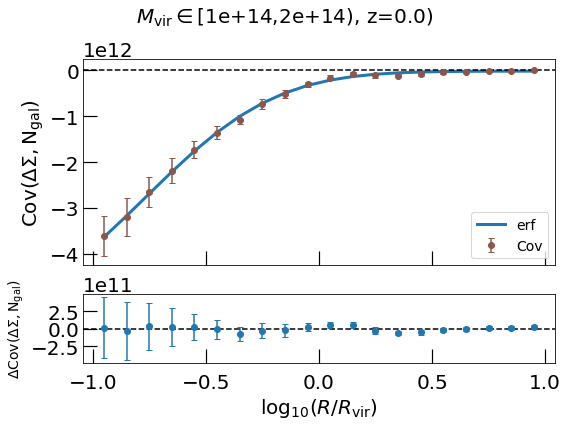

M1e+14-2e+14, z=0.49, 500
logistics
algebraic_2nd
arctan
erf


100%|██████████| 10000/10000 [01:05<00:00, 152.48it/s]


param_0: best fit, upper_err, lower_err:  [0.36394649 0.088093   0.06534305]
param_1: best fit, upper_err, lower_err:  [-0.43189303  0.07755456  0.1124277 ]
param_2: best fit, upper_err, lower_err:  [-1.03914745  0.01565541  0.01743519]
param_3: best fit, upper_err, lower_err:  [7.72080206e+11 1.95028789e+11 1.23703724e+11]
DIC:  [1053.44004204]
BIC:  [1057.14924226]
Chi-square p-value:  0.9417162725546875
Starting params:  [ 3.47939612e-01 -4.16626084e-01 -1.04155553e+00  7.55411643e+11] Minimization convergence:  False
Autocorrelation:  [69.24609044 79.28398271 52.77989707 84.79731469]
R = [1.00367259 1.00432721 1.00187805 1.00463799]


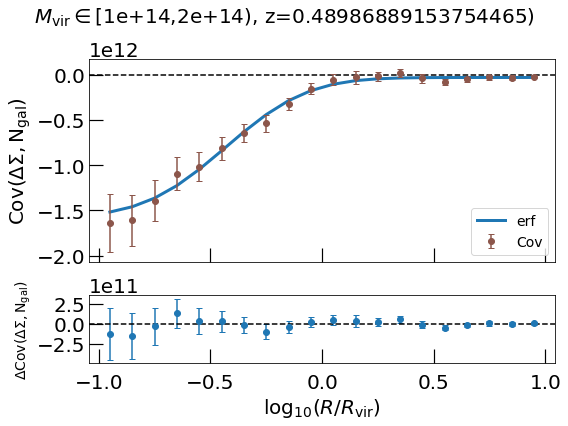

M1e+14-2e+14, z=1.03, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 529.140444
         Iterations: 252
         Function evaluations: 549


100%|██████████| 10000/10000 [01:05<00:00, 152.50it/s]


param_0: best fit, upper_err, lower_err:  [0.21207452 0.05925671 0.05176454]
param_1: best fit, upper_err, lower_err:  [-0.42470129  0.05846747  0.06832779]
param_2: best fit, upper_err, lower_err:  [-1.02474876  0.01326395  0.01414212]
param_3: best fit, upper_err, lower_err:  [5.05756131e+11 9.19281174e+10 7.25799344e+10]
DIC:  [1066.65506103]
BIC:  [1070.33710777]
Chi-square p-value:  0.032562048454704784
Starting params:  [ 2.10623286e-01 -4.20055881e-01 -1.02425652e+00  5.13233796e+11] Minimization convergence:  True
Autocorrelation:  [48.95981296 49.17390805 48.94964855 47.82901101]
R = [1.00012028 0.99984837 1.00247037 1.00010601]


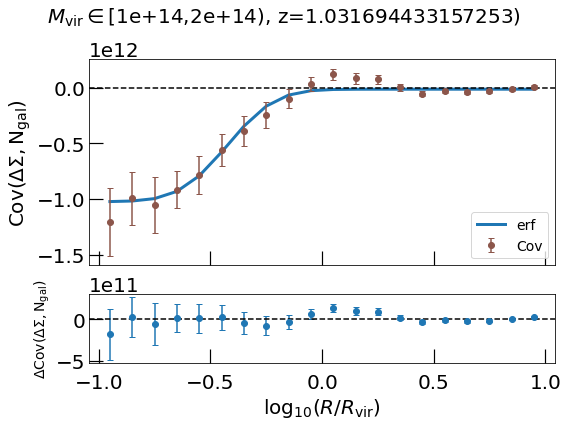

M2e+14-5e+14, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 522.499603
         Iterations: 236
         Function evaluations: 531


100%|██████████| 10000/10000 [01:05<00:00, 153.82it/s]


param_0: best fit, upper_err, lower_err:  [0.40588796 0.04113315 0.03541497]
param_1: best fit, upper_err, lower_err:  [-0.50548473  0.04816677  0.06027372]
param_2: best fit, upper_err, lower_err:  [-0.99658744  0.00358585  0.00372613]
param_3: best fit, upper_err, lower_err:  [1.93484659e+12 2.31063128e+11 1.75066604e+11]
DIC:  [1053.01466568]
BIC:  [1057.00684052]
Chi-square p-value:  0.6461645332053173
Starting params:  [ 4.01294446e-01 -4.99966002e-01 -9.96741158e-01  1.92206259e+12] Minimization convergence:  True
Autocorrelation:  [47.74935749 48.74997712 48.08297671 48.29275417]
R = [1.00001388 1.00008505 0.99962537 1.00007625]


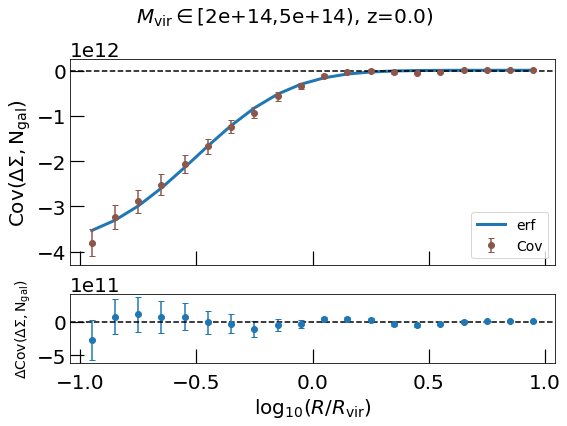

M2e+14-5e+14, z=0.49, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 524.620654
         Iterations: 284
         Function evaluations: 593


100%|██████████| 10000/10000 [01:04<00:00, 154.09it/s]


param_0: best fit, upper_err, lower_err:  [0.20184024 0.07997857 0.06806188]
param_1: best fit, upper_err, lower_err:  [-0.46225169  0.0706435   0.09986163]
param_2: best fit, upper_err, lower_err:  [-0.99451117  0.01469354  0.01418751]
param_3: best fit, upper_err, lower_err:  [4.60789650e+11 1.52580454e+11 1.03177524e+11]
DIC:  [1057.62580515]
BIC:  [1061.36021456]
Chi-square p-value:  0.2686104530218425
Starting params:  [ 1.97574650e-01 -4.58584837e-01 -9.93814208e-01  4.77802629e+11] Minimization convergence:  True
Autocorrelation:  [63.75771697 70.59580317 46.46443093 74.59959673]
R = [1.00101747 1.00230397 1.00159431 1.0065185 ]


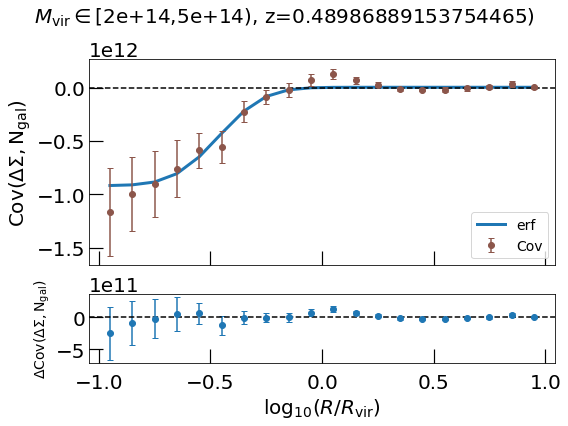

M2e+14-5e+14, z=1.03, 289
logistics
algebraic_2nd
arctan
erf


100%|██████████| 10000/10000 [01:05<00:00, 153.19it/s]


param_0: best fit, upper_err, lower_err:  [1.04098771e-10 8.61318731e-13 9.44474423e-13]
param_1: best fit, upper_err, lower_err:  [-0.34986317  0.00284843  0.00369278]
param_2: best fit, upper_err, lower_err:  [-3.01924042  0.03473849  0.0344318 ]
param_3: best fit, upper_err, lower_err:  [1.00534147e+10 5.22590052e+07 1.20078443e+08]
DIC:  [1061.52989406]
BIC:  [1073.40318469]
Chi-square p-value:  0.07345000534713042
Starting params:  [ 1.04030443e-10 -3.49999629e-01 -3.01945513e+00  1.00382591e+10] Minimization convergence:  False
Autocorrelation:  [nan nan nan nan]
R = [4.40978188e+12 3.74703543e+12 4.62429118e+12 3.45196728e+12]


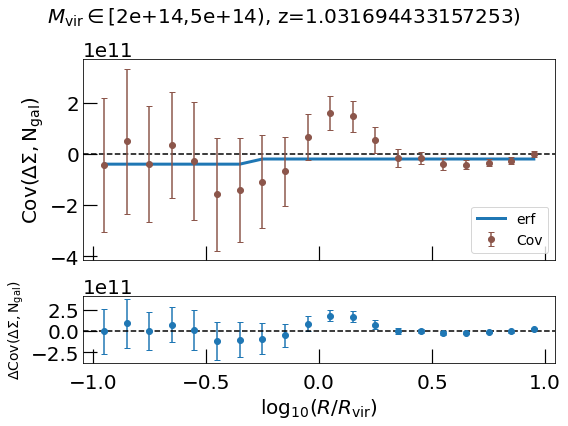

M5e+14-1e+15, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 535.713117
         Iterations: 230
         Function evaluations: 514


100%|██████████| 10000/10000 [01:06<00:00, 151.51it/s]


param_0: best fit, upper_err, lower_err:  [0.27611982 0.03478183 0.03259062]
param_1: best fit, upper_err, lower_err:  [-0.39628681  0.04442457  0.05035805]
param_2: best fit, upper_err, lower_err:  [-1.00626996  0.00505249  0.00504324]
param_3: best fit, upper_err, lower_err:  [1.03838597e+12 1.31993983e+11 1.12746771e+11]
DIC:  [1079.51344439]
BIC:  [1083.43276656]
Chi-square p-value:  0.00017976440391709314
Starting params:  [ 2.74782448e-01 -3.94737403e-01 -1.00627221e+00  1.04289527e+12] Minimization convergence:  True
Autocorrelation:  [47.21719422 48.44425494 45.16567689 47.62640848]
R = [1.00063542 1.00067143 0.99995752 1.00057841]


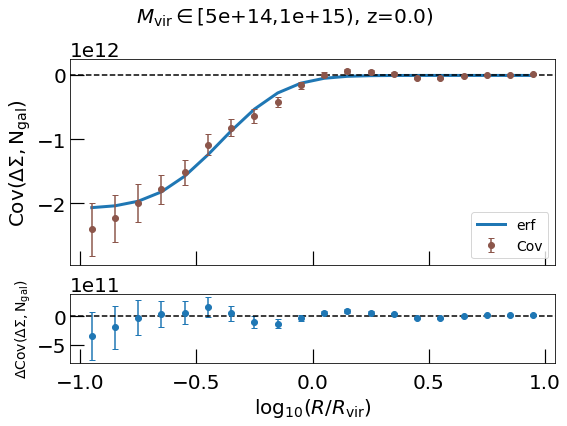

M5e+14-1e+15, z=0.49, 136
logistics
algebraic_2nd
arctan
erf


100%|██████████| 10000/10000 [01:05<00:00, 152.42it/s]


param_0: best fit, upper_err, lower_err:  [1.14350884 2.37613107 0.58484909]
param_1: best fit, upper_err, lower_err:  [-0.81059277  0.66370549  1.48367247]
param_2: best fit, upper_err, lower_err:  [-0.89402199  0.41132772  0.07710069]
param_3: best fit, upper_err, lower_err:  [7.57598876e+11 1.27218874e+12 4.41359935e+11]
DIC:  [1051.96047675]
BIC:  [1092.58237849]
Chi-square p-value:  0.08990794311671135
Starting params:  [ 6.67151800e-01 -5.84844371e-01 -9.32011467e-01  6.40933109e+11] Minimization convergence:  False


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [605.3464517  365.3910545  581.32024175 301.11966647]


Autocorrelation:  [605.3464517  365.3910545  581.32024175 301.11966647]
R = [1.12823515 1.06230304 1.12097733 1.05173307]


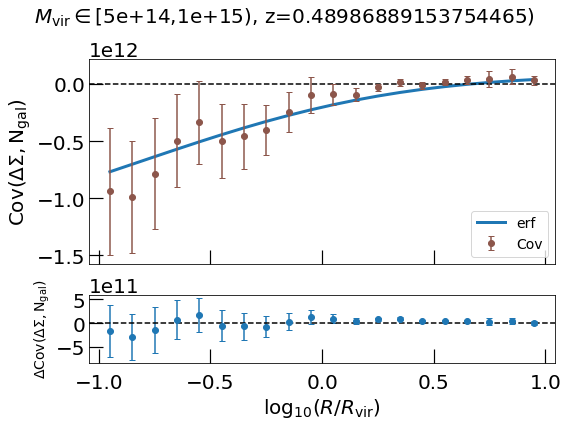

M5e+14-1e+15, z=1.03, 5


In [11]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 20

#fig, axs = plt.subplots(4,3,figsize=(18,18), tight_layout=True, sharex=True)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
            mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
            mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
            cur_df = matched_halo_df[mask]
            print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))

            redshift = 1/cur_a_bin - 1
            redshift_str = '{:.2f}'.format(redshift)
            redshift_str = redshift_str.replace('.','p')

            if len(cur_df) < 100: 
                #axs[i,j].set_visible(False)
                continue

            ##Computing the Covariance##
            ##Compute Cov. and error total
            xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                           np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
            cov_ds_ngal_kllr = output['covariance']
            cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
            cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

            ##Data vector for chains
            x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

            f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6), sharex=True)
            k=0
            for key, value in model_dict.items():
                print(key)
                if key != 'erf': continue 
                Ndim = value['Ndim']
                model = value['model_func']
                x0 = value['x0']


                filename = chains_dir+"R200c_binned/Dsep_R200c/chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, key)

                best_fit_params, flatchain = run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                                 burn_in=burn_in, thin=thin, maxlag=maxlag, savefile=True, filename=filename, verbose=True)

                model_dict[key]['x_final'] = best_fit_params
                fit = model(best_fit_params[:,0], x_data)


                a0.plot(x_data, fit, label=key, color='C{}'.format(k), linewidth=3)
                a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(k), label=key)
                k+=1

            a0.axhline(0, linestyle='--', color='black')
            a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
            a0.legend(loc='lower right', fontsize=14)
            a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

            a1.axhline(0, linestyle='--', color='black')
            #a1.set_ylim([-6e11,3e11])
            a1.set_ylabel(r'$\Delta \rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=14)
            a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

            plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(mass_min, mass_max, 1/cur_a_bin-1), fontsize=20)

            f.tight_layout()
            #f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
            plt.show()

M5e+13-1e+14, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 524.394985
         Iterations: 209
         Function evaluations: 479


100%|██████████| 10000/10000 [00:58<00:00, 171.53it/s]


param_0: best fit, upper_err, lower_err:  [0.48459287 0.06666908 0.05222147]
param_1: best fit, upper_err, lower_err:  [-0.56483422  0.08596438  0.11855299]
param_2: best fit, upper_err, lower_err:  [-0.96864174  0.00957718  0.0084811 ]
param_3: best fit, upper_err, lower_err:  [1.54477894e+12 3.95901666e+11 2.48749346e+11]
DIC:  [1056.82166218]
BIC:  [1060.81270238]
Chi-square p-value:  0.6251525787121907
Starting params:  [ 4.78105281e-01 -5.56033935e-01 -9.67794233e-01  1.52864901e+12] Minimization convergence:  True
Autocorrelation:  [63.06158418 69.02034485 53.36277018 72.76075093]
R = [1.00161118 1.00156406 1.00122576 1.0020403 ]


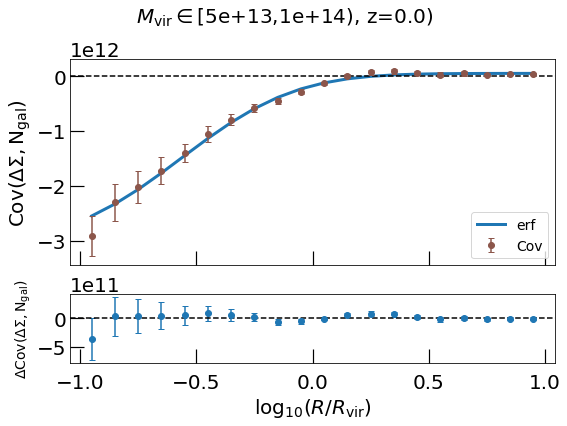

M5e+13-1e+14, z=0.49, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 515.284585
         Iterations: 227
         Function evaluations: 501


100%|██████████| 10000/10000 [00:59<00:00, 166.70it/s]


param_0: best fit, upper_err, lower_err:  [0.3147191  0.03819998 0.03525051]
param_1: best fit, upper_err, lower_err:  [-0.22509755  0.03817988  0.04502187]
param_2: best fit, upper_err, lower_err:  [-0.98952819  0.0136644   0.01389118]
param_3: best fit, upper_err, lower_err:  [5.70195604e+11 5.21477770e+10 4.47059696e+10]
DIC:  [1038.63805617]
BIC:  [1042.57950671]
Chi-square p-value:  0.9187146433545302
Starting params:  [ 3.11349583e-01 -2.22384835e-01 -9.89454772e-01  5.70820588e+11] Minimization convergence:  True
Autocorrelation:  [45.59734853 45.65454029 47.05412459 47.18832581]
R = [0.99995868 1.00020666 1.00097181 1.00038633]


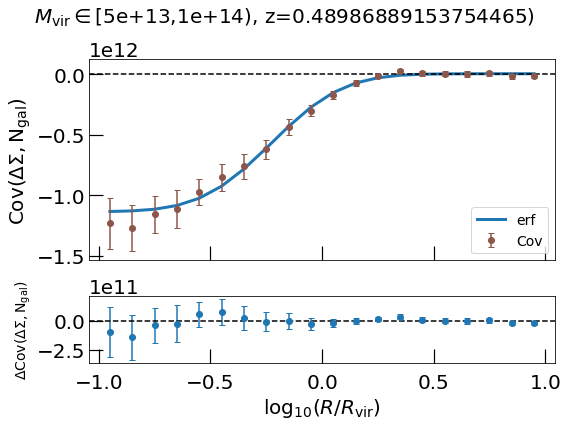

M5e+13-1e+14, z=1.03, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 513.170819
         Iterations: 282
         Function evaluations: 598


100%|██████████| 10000/10000 [00:59<00:00, 168.77it/s]


param_0: best fit, upper_err, lower_err:  [0.22051443 0.07814433 0.07143071]
param_1: best fit, upper_err, lower_err:  [0.01346878 0.07423242 0.0889257 ]
param_2: best fit, upper_err, lower_err:  [-1.06029038  0.03687093  0.0397197 ]
param_3: best fit, upper_err, lower_err:  [1.40184676e+11 2.69167583e+10 2.24100196e+10]
DIC:  [1034.54254502]
BIC:  [1038.40386942]
Chi-square p-value:  0.7414160629706791
Starting params:  [ 2.17509528e-01  1.55819793e-02 -1.05753890e+00  1.43418404e+11] Minimization convergence:  True
Autocorrelation:  [44.62405827 46.38706708 43.06938695 44.55214286]
R = [0.99969482 0.9997515  1.00013696 0.9996025 ]


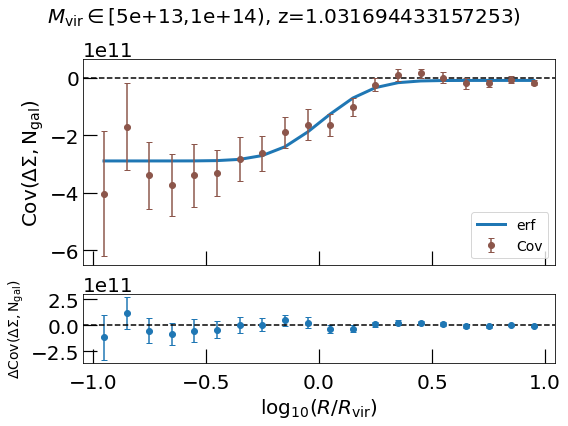

M1e+14-2e+14, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 517.711809
         Iterations: 252
         Function evaluations: 566


100%|██████████| 10000/10000 [00:58<00:00, 169.78it/s]


param_0: best fit, upper_err, lower_err:  [0.52678239 0.09448581 0.07344288]
param_1: best fit, upper_err, lower_err:  [-0.66244955  0.11831762  0.17906534]
param_2: best fit, upper_err, lower_err:  [-1.001479    0.00408355  0.00493154]
param_3: best fit, upper_err, lower_err:  [1.77583853e+12 7.02149059e+11 3.75966241e+11]
DIC:  [1043.29633561]
BIC:  [1047.47288454]
Chi-square p-value:  0.9977889435610025
Starting params:  [ 5.12993433e-01 -6.43446837e-01 -1.00220602e+00  1.72743495e+12] Minimization convergence:  True
Autocorrelation:  [104.58574381 116.68352542  59.02252147 131.06655293]
R = [1.00614176 1.00694849 1.00100721 1.01023855]


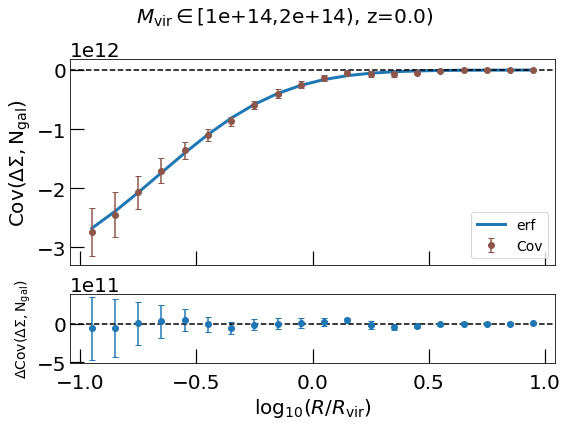

M1e+14-2e+14, z=0.49, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 514.813457
         Iterations: 251
         Function evaluations: 551


100%|██████████| 10000/10000 [01:01<00:00, 162.12it/s]


param_0: best fit, upper_err, lower_err:  [0.33666787 0.07529196 0.06217885]
param_1: best fit, upper_err, lower_err:  [-0.37120228  0.07664427  0.10415469]
param_2: best fit, upper_err, lower_err:  [-1.018215    0.01142717  0.0124152 ]
param_3: best fit, upper_err, lower_err:  [5.01595480e+11 1.08736882e+11 7.36127621e+10]
DIC:  [1037.95364408]
BIC:  [1041.65631187]
Chi-square p-value:  0.9332006528318967
Starting params:  [ 3.29535109e-01 -3.62387304e-01 -1.01861929e+00  4.99794975e+11] Minimization convergence:  True
Autocorrelation:  [56.18522911 59.46077741 49.12551631 64.32749372]
R = [1.00094622 1.00091896 1.00165785 1.00191548]


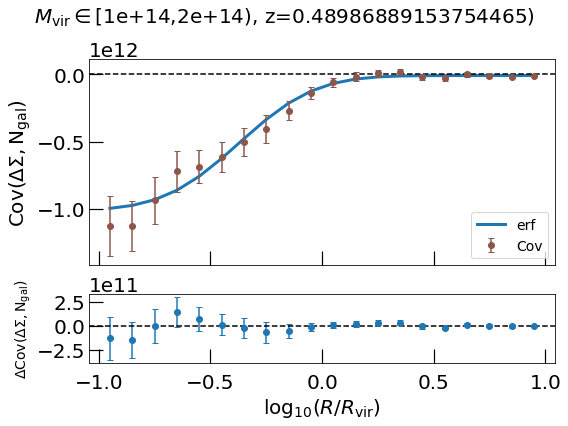

M1e+14-2e+14, z=1.03, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 511.993827
         Iterations: 268
         Function evaluations: 573


100%|██████████| 10000/10000 [00:58<00:00, 171.65it/s]


param_0: best fit, upper_err, lower_err:  [0.31421458 0.09441006 0.07355037]
param_1: best fit, upper_err, lower_err:  [-0.29069475  0.08762475  0.11780336]
param_2: best fit, upper_err, lower_err:  [-1.04780748  0.02173453  0.02639581]
param_3: best fit, upper_err, lower_err:  [2.25611830e+11 6.31239859e+10 4.40585235e+10]
DIC:  [1032.55861093]
BIC:  [1036.09498029]
Chi-square p-value:  0.5571252899089845
Starting params:  [ 3.01513685e-01 -2.79825988e-01 -1.04902785e+00  2.27231534e+11] Minimization convergence:  True
Autocorrelation:  [59.50119726 62.87196661 55.77200045 62.3514207 ]
R = [1.00136399 1.0021384  1.00054463 1.0033415 ]


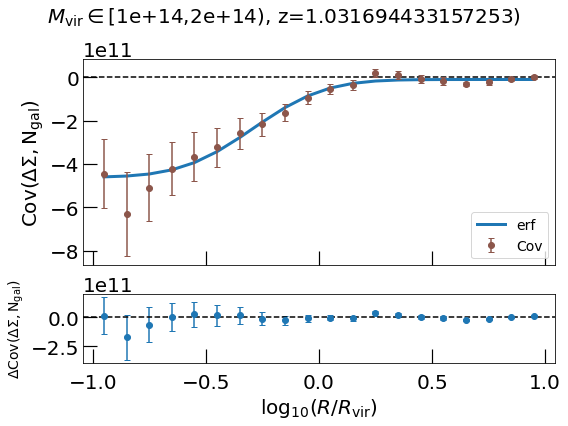

M2e+14-5e+14, z=0.00, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 521.963321
         Iterations: 228
         Function evaluations: 520


100%|██████████| 10000/10000 [00:55<00:00, 181.51it/s]


param_0: best fit, upper_err, lower_err:  [0.39184523 0.04636609 0.03899293]
param_1: best fit, upper_err, lower_err:  [-0.52805691  0.05388988  0.07197989]
param_2: best fit, upper_err, lower_err:  [-0.99981265  0.00445212  0.00456412]
param_3: best fit, upper_err, lower_err:  [1.81695098e+12 2.77786651e+11 1.97924344e+11]
DIC:  [1052.10078353]
BIC:  [1055.92869143]
Chi-square p-value:  0.7103987755782005
Starting params:  [ 3.86706897e-01 -5.21659414e-01 -9.99913904e-01  1.79816683e+12] Minimization convergence:  True
Autocorrelation:  [46.55537727 47.66780266 49.6381978  49.31965036]
R = [1.00138575 1.00155228 1.00158634 1.00130956]


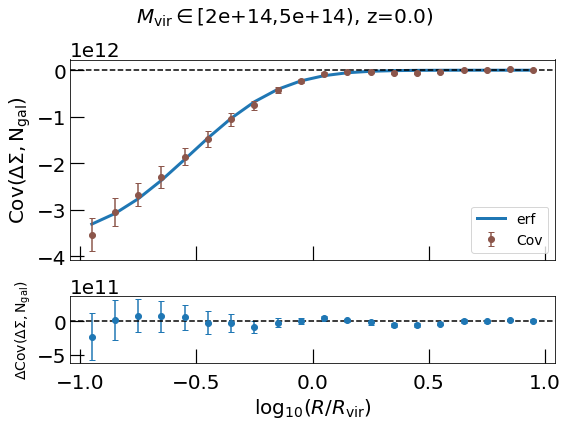

M2e+14-5e+14, z=0.49, 500
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 520.282383
         Iterations: 235
         Function evaluations: 531


100%|██████████| 10000/10000 [00:55<00:00, 178.77it/s]


param_0: best fit, upper_err, lower_err:  [0.26178277 0.11129846 0.08485965]
param_1: best fit, upper_err, lower_err:  [-0.47403204  0.1037003   0.16430468]
param_2: best fit, upper_err, lower_err:  [-1.00044267  0.01274084  0.01403266]
param_3: best fit, upper_err, lower_err:  [3.77446655e+11 1.69746356e+11 9.92437297e+10]
DIC:  [1049.35860849]
BIC:  [1052.7104092]
Chi-square p-value:  0.3890466960048683
Starting params:  [ 2.54647474e-01 -4.63668605e-01 -1.00049702e+00  3.89690453e+11] Minimization convergence:  True
Autocorrelation:  [ 86.36648378 105.51061067  50.39708252 118.46979392]
R = [1.0135033  1.02941508 1.00112719 1.07803976]


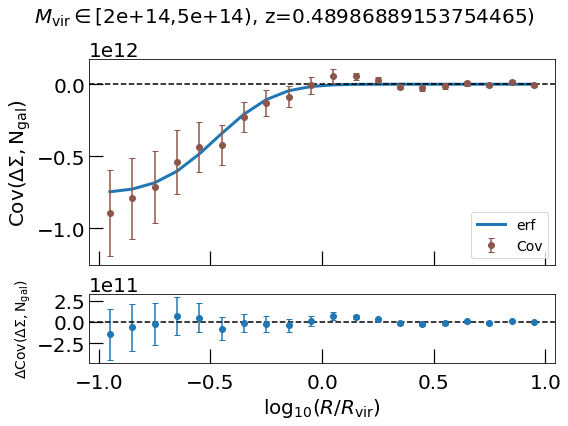

M2e+14-5e+14, z=1.03, 289
logistics
algebraic_2nd
arctan
erf


100%|██████████| 10000/10000 [00:58<00:00, 170.65it/s]


param_0: best fit, upper_err, lower_err:  [5.09818115 3.26253811 3.3826835 ]
param_1: best fit, upper_err, lower_err:  [0.30728393 3.23517157 3.45995516]
param_2: best fit, upper_err, lower_err:  [-0.74507959  0.76975605  0.655416  ]
param_3: best fit, upper_err, lower_err:  [2.05125116e+10 3.44433156e+10 8.39517019e+09]
DIC:  [1048.32300806]
BIC:  [1058.24997498]
Chi-square p-value:  0.14172728741866292
Starting params:  [ 6.22629143e-02 -1.01956183e-01 -1.22009692e+00  5.60180875e+10] Minimization convergence:  False


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [137.06457782 154.36455015 187.2540836  296.01897808]


Autocorrelation:  [137.06457782 154.36455015 187.2540836  296.01897808]
R = [1.00713863 1.01068353 1.01374072 1.04132129]


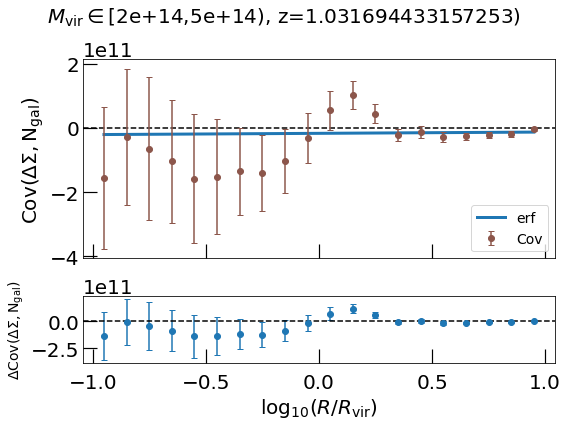

M5e+14-1e+15, z=0.00, 500
logistics
algebraic_2nd
arctan
erf


100%|██████████| 10000/10000 [00:57<00:00, 172.53it/s]


param_0: best fit, upper_err, lower_err:  [0.27345571 0.0352956  0.03071006]
param_1: best fit, upper_err, lower_err:  [-0.48172375  0.03686457  0.04419184]
param_2: best fit, upper_err, lower_err:  [-1.01581769  0.00619304  0.00670845]
param_3: best fit, upper_err, lower_err:  [1.13292703e+12 1.23257579e+11 9.70190003e+10]
DIC:  [1077.2494875]
BIC:  [1081.14885135]
Chi-square p-value:  0.0007191898722559431
Starting params:  [ 2.71046205e-01 -4.78743570e-01 -1.01614866e+00  1.13288479e+12] Minimization convergence:  False
Autocorrelation:  [48.33389368 47.99569602 46.48218874 47.04995828]
R = [1.00161738 1.00146829 1.00087662 1.00092793]


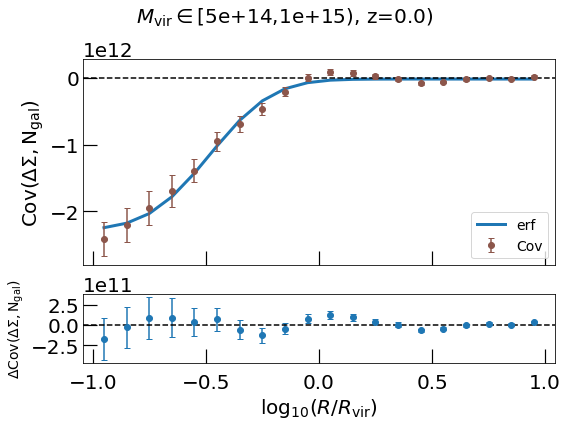

M5e+14-1e+15, z=0.49, 136
logistics
algebraic_2nd
arctan
erf
Optimization terminated successfully.
         Current function value: 525.931477
         Iterations: 228
         Function evaluations: 518


100%|██████████| 10000/10000 [00:57<00:00, 174.62it/s]


param_0: best fit, upper_err, lower_err:  [2.17195661 4.69540492 1.6934277 ]
param_1: best fit, upper_err, lower_err:  [-0.38683077  2.12499133  1.95307991]
param_2: best fit, upper_err, lower_err:  [-0.97511189  0.78850834  0.17519758]
param_3: best fit, upper_err, lower_err:  [1.66087626e+11 4.01726381e+11 1.40888872e+11]
DIC:  [1001.23560834]
BIC:  [1138.30892786]
Chi-square p-value:  3.802905768068854e-10
Starting params:  [ 4.92391312e-01 -4.41853419e-01 -1.03058129e+00  3.91774681e+11] Minimization convergence:  True


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [514.0927661  299.40334253 387.49972448 411.14602413]


Autocorrelation:  [514.0927661  299.40334253 387.49972448 411.14602413]
R = [1.03837731 1.01774965 1.02562167 1.08711813]


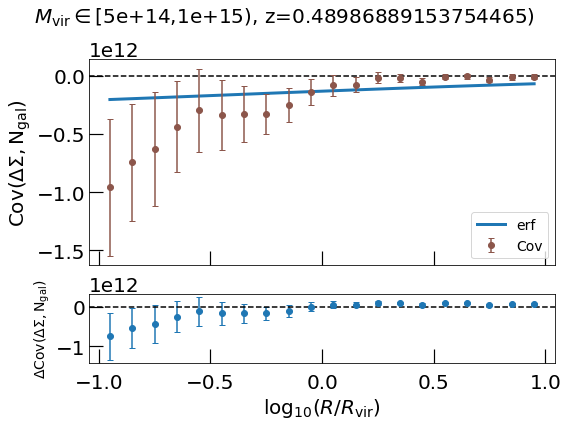

M5e+14-1e+15, z=1.03, 5


In [15]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 20

#fig, axs = plt.subplots(4,3,figsize=(18,18), tight_layout=True, sharex=True)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
            mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
            mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
            cur_df = matched_halo_df[mask]
            print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))

            redshift = 1/cur_a_bin - 1
            redshift_str = '{:.2f}'.format(redshift)
            redshift_str = redshift_str.replace('.','p')

            if len(cur_df) < 100: 
                #axs[i,j].set_visible(False)
                continue

            ##Computing the Covariance##
            ##Compute Cov. and error total
            xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                           np.log10(np.array(cur_df['Ngal_Dsep_1'],dtype=float)), nBootstrap=nBootstrap)
            cov_ds_ngal_kllr = output['covariance']
            cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
            cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

            ##Data vector for chains
            x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

            f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6), sharex=True)
            k=0
            for key, value in model_dict.items():
                print(key)
                if key != 'erf': continue 
                Ndim = value['Ndim']
                model = value['model_func']
                x0 = value['x0']


                filename = chains_dir+"R200c_binned/Dsep_1/chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, key)

                best_fit_params, flatchain = run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                                 burn_in=burn_in, thin=thin, maxlag=maxlag, savefile=True, filename=filename, verbose=True)

                model_dict[key]['x_final'] = best_fit_params
                fit = model(best_fit_params[:,0], x_data)


                a0.plot(x_data, fit, label=key, color='C{}'.format(k), linewidth=3)
                a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(k), label=key)
                k+=1

            a0.axhline(0, linestyle='--', color='black')
            a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
            a0.legend(loc='lower right', fontsize=14)
            a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

            a1.axhline(0, linestyle='--', color='black')
            #a1.set_ylim([-6e11,3e11])
            a1.set_ylabel(r'$\Delta \rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=14)
            a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

            plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(mass_min, mass_max, 1/cur_a_bin-1), fontsize=20)

            f.tight_layout()
            #f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
            plt.show()

## Configure the (M,z) bins to run

In [9]:
## MCMC config
Nwalkers = 50
Nsample = int(2e4)
burn_in = 500
thin = 50 
maxlag=1000
#x0 = [0.5,-0.5,-1,1e11]

In [10]:
#mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
mass_bin_edges = [5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]
#a_bins = [1, 0.6712, 0.4922]
a_bins = [1]


M5e+13-1e+14, z=0.49, 500
logistics


NameError: name 'Nwalkers' is not defined

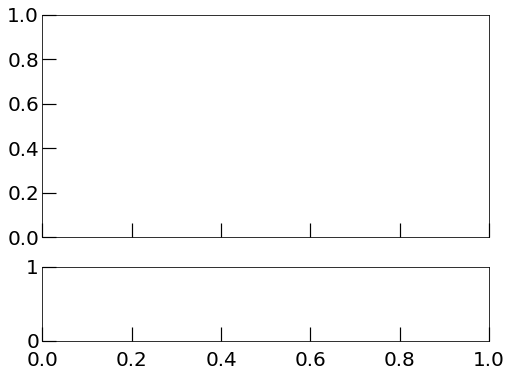

In [8]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 20

#fig, axs = plt.subplots(4,3,figsize=(18,18), tight_layout=True, sharex=True)

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
            mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
            mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
            cur_df = matched_halo_df[mask]
            print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))

            redshift = 1/cur_a_bin - 1
            redshift_str = '{:.2f}'.format(redshift)
            redshift_str = redshift_str.replace('.','p')

            if len(cur_df) < 100: 
                #axs[i,j].set_visible(False)
                continue

            ##Computing the Covariance##
            ##Compute Cov. and error total
            xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                           np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
            cov_ds_ngal_kllr = output['covariance']
            cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
            cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

            ##Data vector for chains
            x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

            f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6), sharex=True)
            k=0
            for key, value in model_dict.items():
                print(key)
                #if key == 'erf': continue 
                Ndim = value['Ndim']
                model = value['model_func']
                x0 = value['x0']


                filename = chainsdir+"R200c_binned/Dsep_R200c/chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, key)

                best_fit_params, flatchain = run_model_chains(Nwalkers, Ndim, Nsample, model, x_data, y_data, y_err, x0, \
                                 burn_in=burn_in, thin=thin, maxlag=maxlag, savefile=True, filename=filename, verbose=True)

                model_dict[key]['x_final'] = best_fit_params
                fit = model(best_fit_params[:,0], x_data)


                a0.plot(x_data, fit, label=key, color='C{}'.format(k), linewidth=3)
                a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C{}'.format(k), label=key)
                k+=1

            a0.axhline(0, linestyle='--', color='black')
            a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
            a0.legend(loc='lower right', fontsize=14)
            a0.set_ylabel(r'$\rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=20)

            a1.axhline(0, linestyle='--', color='black')
            #a1.set_ylim([-6e11,3e11])
            a1.set_ylabel(r'$\Delta \rm{Cov}(\Delta\Sigma, N_{\rm gal})$', fontsize=14)
            a1.set_xlabel(r'$\log_{10}(R/R_{\rm vir})$', fontsize=20)

            plt.suptitle(r'$M_{\rm vir} \in$' + '[{:.2g},{:.2g}), z={})'.format(mass_min, mass_max, 1/cur_a_bin-1), fontsize=20)

            f.tight_layout()
            #f.savefig(plot_dir+'cov_all_models_data_vs_fit_M{:.2g}_{:.2g}_z{}.pdf'.format(mass_min, mass_max, redshift_str))
            plt.show()

## Cornerplot

In [ ]:
import corner
tmp = corner.corner(flatchain.T, labels=['gamma', 'tau', 'h', r'$10^{12}\times s$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e12,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
#tmp.savefig(plot_dir + 'mcmc_logistic_cornerplot.pdf')